In [1]:
using PyPlot
using JLD
using ScikitLearn: @sk_import, fit!, predict
using ScikitLearn.Utils: meshgrid 

In [2]:
code_path = "../src/"

push!(LOAD_PATH, code_path)
using AnomalyDetection

In [3]:
dataset = load("toy_data_3.jld")["data"]

AnomalyDetection.Dataset([0.803442 0.804605 … 0.252366 -0.216809; 0.821998 0.834235 … 0.714171 1.09756], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

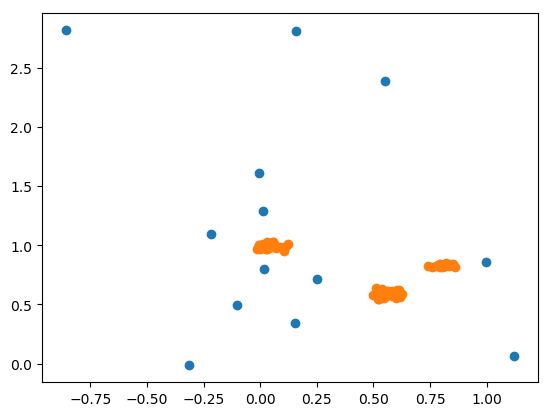

In [4]:
figure()
X = dataset.data
y = dataset.labels
scatter(X[1, y.==1], X[2, y.==1])
scatter(X[1, y.==0], X[2, y.==0])
show()

In [5]:
# import the isolation forest from SKlearn
@sk_import ensemble: IsolationForest

PyObject <class 'sklearn.ensemble.iforest.IsolationForest'>

In [6]:
n_estimators=100  # how many estimators to use
max_samples="auto" # how many samples to draw from X for each estimator
contamination = size(y[y.==1],1)/size(y[y.==0],1) # to set the decision threshold
max_features=1.0 # how many features to use (if float, then it is a ratio)
bootstrap=false # bootstrapping - if false, sample without replacing
n_jobs=1 # how many cores to use
#random_state=None # seed or generator
verbose=0 # verbosity of the fitting
isoforest = IsolationForest(n_estimators, max_samples, contamination, max_features, bootstrap,
    n_jobs, verbose)

PyObject IsolationForest(bootstrap=False, contamination=0.14444444444444443,
        max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=1,
        random_state=0, verbose=0)

In [7]:
tryhat, tsthat = AnomalyDetection.quickvalidate!(dataset, dataset, isoforest)


 Training data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 13
  tn = 88
  fp = 2
  fn = 0
precision: 0.8666666666666667
recall: 1.0
f1score: 0.9285714285714286
equal error rate: 0.011111111111111112

 Testing data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 13
  tn = 88
  fp = 2
  fn = 0
precision: 0.8666666666666667
recall: 1.0
f1score: 0.9285714285714286
equal error rate: 0.011111111111111112


([0, 0, 0, 0, 1, 0, 0, 0, 0, 0  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

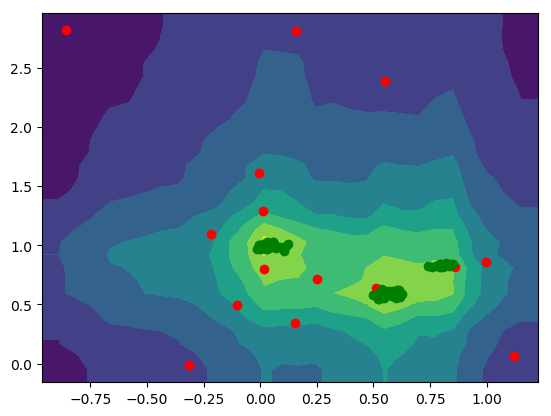

In [8]:
# plot heatmap of the fit
figure()
scatter(X[1, tryhat.==1], X[2, tryhat.==1], c = "r")
ax = gca()
ylim = ax[:get_ylim]()
xlim = ax[:get_xlim]()
xx, yy = meshgrid(linspace(xlim[1], xlim[2], 30), linspace(ylim[1], ylim[2], 30))
zz = zeros(size(xx))
for i in 1:size(xx, 1)
    for j in 1:size(xx, 2)
        zz[i,j] = ScikitLearn.decision_function(isoforest, [xx[i,j], yy[i,j]]')[1]
    end
end
contourf(xx, yy, zz)
scatter(X[1, tryhat.==1], X[2, tryhat.==1], c = "r")
scatter(X[1, tsthat.==0], X[2, tsthat.==0], c = "g")
show()